# Segmentation of Road from Satellite imagery

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
# Change directory to working folder
%cd "/content/gdrive/My Drive/CIL2020_Project/model2_segmentation"

/content/gdrive/My Drive/CIL2020_Project/model2_segmentation


## Importing Libraries

In [ ]:
# %tensorflow_version 1.x

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py


Using TensorFlow backend.


## Loading Data

In [ ]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = './Data/ciltrain_images.h5py'
mask_file = './Data/ciltrain_masks.h5py'

In [ ]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(900, 256, 256, 3)


In [ ]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
# print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(900, 256, 256)


## Displaying few Samples

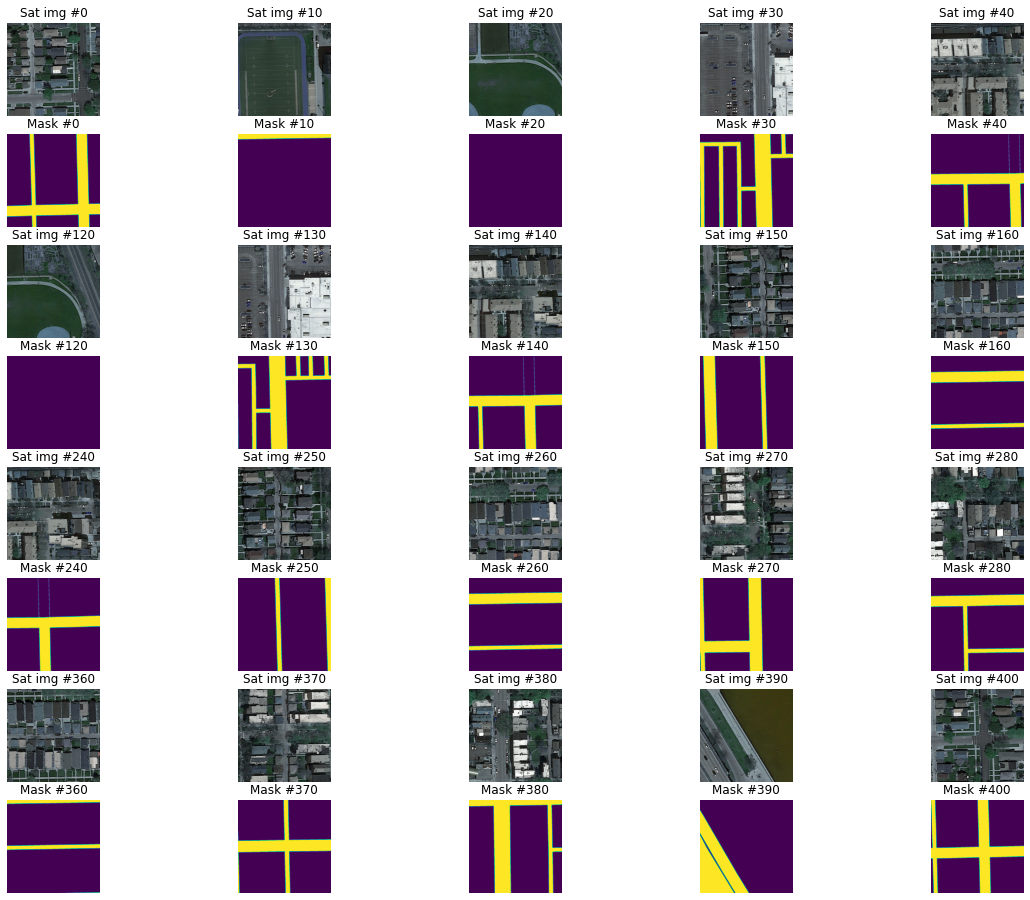

In [ ]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [ ]:
masks = np.expand_dims(masks, -1)

In [ ]:
print(masks.shape)
print(masks[10][:,:,0])

(900, 256, 256, 1)
[[237 237 237 ... 237 237 237]
 [237 237 237 ... 237 237 237]
 [237 237 237 ... 237 237 237]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
# Categorize the mask data into 0 and 1
def relabel(tensor, LABELING_THRESHOLD):
  tensor[tensor < LABELING_THRESHOLD] = int(0)
  tensor[tensor >= LABELING_THRESHOLD] = int(1)
  return tensor

In [ ]:
LABELING_THRESHOLD = 128
masks = relabel(masks, LABELING_THRESHOLD)

(900, 256, 256, 1)


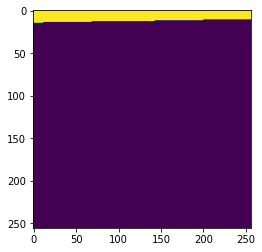

In [ ]:
print(masks.shape)
plt.imshow(masks[10][:,:,0])

### Data Preprocessing
Split the data into training and validation datasets. Augment the image dataset.

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 56
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=SEED)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("VALIDATION SET")
print(val_images.shape)
print(val_masks.shape)

TRAIN SET
(720, 256, 256, 3)
(720, 256, 256, 1)
VALIDATION SET
(180, 256, 256, 3)
(180, 256, 256, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator for training dataset. Define the arguments.
train_datagen_args = dict(rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True)

# Define the generators for images and masks of training set.
train_image_datagen = ImageDataGenerator(rescale= 1./255, **train_datagen_args)
train_mask_datagen = ImageDataGenerator(**train_datagen_args)


In [ ]:
# Define the batch size
BATCH_SIZE = 16
SEED = 56

# For training set: do same augmentation for both images and masks and flow them in given batch size
train_image_generator = train_image_datagen.flow(train_images, seed=SEED, batch_size=BATCH_SIZE, shuffle=True)
train_mask_generator = train_mask_datagen.flow(train_masks, seed=SEED, batch_size=BATCH_SIZE, shuffle=True)

def train_generator():
  while True:
    image_batch = train_image_generator.next()
    mask_batch = relabel(train_mask_generator.next(), 0.5)
    yield image_batch, mask_batch


In [ ]:
image_train_batch, mask_train_batch = next(train_generator())
print(image_train_batch.shape)
print(mask_train_batch.shape)

(16, 256, 256, 3)
(16, 256, 256, 1)


tf.Tensor([1. 0.], shape=(2,), dtype=float32)


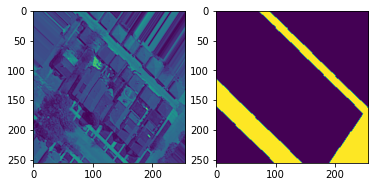

In [ ]:
plt.subplot(121)
plt.imshow(image_train_batch[3][:,:,0])
plt.subplot(122)
plt.imshow(mask_train_batch[3][:,:,0])
y, idx = tf.unique(mask_train_batch[15][:,0,0])
print(y)

## Defining our model
Define an U-Net architecture with base model
from either MobileNetV2, ResNet50V2, or VGG16

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
# Function to get layer index of a model by layer name
def getLayerIndexByName(model, your_layer_name):
  layer_names = [layer.name for layer in model.layers]
  layer_idx = layer_names.index(your_layer_name)
  return layer_idx

In [ ]:
def UNetModel(base_model, skip_connection_names, encoder_last_layer_name, up_filters):

  inputs = Input((None, None, 3), name="input_image")
  
  # Define encoder
  encoder = base_model(input_tensor = inputs, include_top=False, weights="imagenet")
  # encoder = base_model(input_tensor=inputs, include_top=False, weights=None)
  encoder_output =  encoder.get_layer(encoder_last_layer_name).output
  encoder.trainable = False
  x = encoder_output

  # Define bottleneck
  x = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)

  # Define decoder
  for i in range(1, len(skip_connection_names)+1, 1):
    # Define dropout rate for layers
    if i==len(skip_connection_names):
      drop_rate = 0.1
    else:
      drop_rate = 0.2

    # Up-sampling using transpose convolution
    x = Conv2DTranspose(up_filters[-i], (2, 2), strides=(2, 2), padding='same')(x)
    x_skip = encoder.get_layer(skip_connection_names[-i]).output
    x = Concatenate()([x, x_skip])

    # Add two convolutional layers in the block
    x = Conv2D(up_filters[-i], (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)
    # x = Activation("relu")(x)

    x = Conv2D(up_filters[-i], (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    # x = Dropout(drop_rate)(x)
    # x = Activation("relu")(x)

  # Define output layer (1x1 convolution)
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

  # return the model
  model = Model(inputs, outputs)
  return model

In [ ]:
# Initialize a model based on MobileNetV2
base_model = MobileNetV2
skip_connection_names = ["input_image", "block_1_expand_relu",  "block_3_expand_relu", "block_6_expand_relu"]
encoder_last_layer_name = "block_13_expand_relu"
up_filters = [16, 32, 64, 128]
model = UNetModel(base_model, skip_connection_names, encoder_last_layer_name, up_filters)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
# # Initialize a model based on ResNet50V2
# base_model = ResNet50V2
# skip_connection_names = ["input_image", "conv1_conv",  "conv2_block3_1_relu", "conv3_block4_1_relu"]
# encoder_last_layer_name = "conv4_block6_1_relu"
# up_filters = [16, 32, 64, 128]
# model = UNetModel(base_model, skip_connection_names, encoder_last_layer_name, up_filters)
# model.summary()

In [ ]:
# # Initialize a model based on VGG16
# base_model = VGG16
# skip_connection_names = ["block1_conv2", "block2_conv2",  "block3_conv3", "block4_conv3"]
# encoder_last_layer_name = "block5_conv3"
# up_filters = [16, 32, 64, 128]
# model = UNetModel(base_model, skip_connection_names, encoder_last_layer_name, up_filters)
# model.summary()

In [ ]:
idx = getLayerIndexByName(model, "block_13_expand_relu")
print(idx)
print(len(model.layers[:idx+1]))
print(len(model.layers))
for layer in model.layers[idx-10:idx+10]:
  print(layer.trainable)

119
120
154
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
def down_block(filter_size, drop_rate, x):
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  conv = BatchNormalization() (conv)
  conv = Dropout(drop_rate) (conv)
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv)
  conv = BatchNormalization() (conv)
  pooling = MaxPooling2D((2, 2)) (conv)
  return conv, pooling

def bottleneck(filter_size, drop_rate, x):
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  conv = BatchNormalization() (conv)
  conv = Dropout(drop_rate) (conv)
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv)
  conv = BatchNormalization() (conv)
  return conv

def up_block(filter_size, drop_rate, x, skip_connection):
  upsample = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same') (x)
  # upsample = UpSampling2D((2, 2))(x)
  upsample = Concatenate()([upsample, skip_connection])
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample)
  conv = BatchNormalization() (conv)
  conv = Dropout(drop_rate) (conv)
  conv = Conv2D(filter_size, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv)
  conv = BatchNormalization() (conv)
  return conv



In [ ]:
def WNetModel(unet_model):
  unet_model.trainable = False
  
  inputs = Input((None, None, 3), name="input_image")
  x = unet_model(inputs)
  x = Concatenate()([x, inputs])
  
  conv1, pooling1 = down_block(16, 0.1, x)
  conv2, pooling2 = down_block(32, 0.1, pooling1)
  conv3, pooling3 = down_block(64, 0.2, pooling2)
  conv4, pooling4 = down_block(128, 0.2, pooling3)

  conv5 = bottleneck(256, 0.3, pooling4)
  
  conv6 = up_block(128, 0.2, conv5, conv4)
  conv7 = up_block(64, 0.2, conv6, conv3)
  conv8 = up_block(32, 0.1, conv7, conv2)
  conv9 = up_block(16, 0.1, conv8, conv1)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

  # return the model
  model = Model(inputs, outputs)
  return model

In [ ]:
# Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
# unet_model = tf.keras.models.load_model("./models/model_MobileNetV2_IoU_608.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [ ]:
# base_model = MobileNetV2
# skip_connection_names = ["input_layer", "block_1_expand_relu",  "block_3_expand_relu", "block_6_expand_relu"]
# encoder_last_layer_name = "block_13_expand_relu"
# up_filters = [16, 32, 64, 128]
# wnet_model = WNetModel(unet_model)
# wnet_model.summary()
# len(wnet_model.layers)

### Compiling the Model
Defining custom loss functions and accuracy metrics. Complie the model with
base learning rate


In [ ]:
# # load the model again if the training was interrupted
# model = tf.keras.models.load_model("./models/model_MobileNet_IoU.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
# model.load_weights("./weights/weights.60-0.1708.h5")
# model.save("models/model_ResNet50V2_IoU.h5")

In [ ]:
# # Set the encoder as not trainable
# model.trainable = True
# idx = getLayerIndexByName(model, "conv4_block6_1_relu")
# print(idx)
# print(len(model.layers[:idx+1]))
# print(len(model.layers))
# for layer in model.layers[:idx+1]:
#   layer.trainable =  False

In [ ]:
from tensorflow.keras.optimizers import Adam
BASE_LEARNING_RATE = 0.0008
# opt = Adam(learning_rate=BASE_LEARNING_RATE)
model.compile(
      optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
      loss=soft_dice_loss,
      # loss="binary_crossentropy",
      metrics=[iou_coef])
      # metrics=['accuracy'])

### Training the Model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

total_epochs = 100
initial_epoch = 55
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_delta=0.002, cooldown=0, min_lr=0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=10, verbose=1, mode='min', restore_best_weights = True)
checkpoint = ModelCheckpoint("weights/weightsMN2.{epoch:02d}-{loss:.4f}.h5", monitor='val_loss', mode='min', seve_best_only=True, save_weights_only=True, period=5)

In [ ]:
history = model.fit(train_generator(), 
                    validation_data=(val_images/255.0, val_masks),
                    steps_per_epoch= len(train_images)//BATCH_SIZE, 
                    epochs=total_epochs,
                    # initial_epoch = 55, 
                    callbacks=[reduce_learningrate, early_stopping, checkpoint])

model.save("models/model_MobileNetV2Structure_IoU_608.h5")

Epoch 1/100
45/45 [==============================] - 277s 6s/step - loss: 0.5462 - iou_coef: 0.2862 - val_loss: 0.6682 - val_iou_coef: 0.1986 - lr: 8.0000e-04
Epoch 2/100
45/45 [==============================] - 274s 6s/step - loss: 0.4369 - iou_coef: 0.3789 - val_loss: 0.9911 - val_iou_coef: 0.0049 - lr: 8.0000e-04
Epoch 3/100
45/45 [==============================] - 276s 6s/step - loss: 0.3792 - iou_coef: 0.4386 - val_loss: 0.8726 - val_iou_coef: 0.0695 - lr: 8.0000e-04
Epoch 4/100
45/45 [==============================] - 278s 6s/step - loss: 0.3693 - iou_coef: 0.4447 - val_loss: 0.9995 - val_iou_coef: 0.0019 - lr: 8.0000e-04
Epoch 5/100
45/45 [==============================] - 278s 6s/step - loss: 0.3264 - iou_coef: 0.4927 - val_loss: 0.9998 - val_iou_coef: 0.0038 - lr: 8.0000e-04
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 0.3214 - iou_coef: 0.4993
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.
45/45 [======================

In [ ]:
print(model.layers[79].name)

block_8_project


### W-Net Model Training

In [ ]:
wnet_model.load_weights("./weights/weightsW.25-0.1193.h5")

wnet_model.trainable = True
for layer in wnet_model.layers[:2]:
  layer.trainable = False
print(wnet_model.get_layer("model_10").trainable)

False


In [ ]:
for layer in wnet_model.layers[:]:
  print(layer.name, layer.trainable)

In [ ]:
from tensorflow.keras.optimizers import Adam
BASE_LEARNING_RATE = 0.005
# opt = Adam(learning_rate=BASE_LEARNING_RATE)
model = wnet_model
model.compile(
      optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
      loss=soft_dice_loss,
      # loss="binary_crossentropy",
      metrics=[iou_coef])
      # metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

total_epochs = 100
initial_epoch = 0
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.001, cooldown=0, min_lr=0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=10, verbose=1, mode='min', restore_best_weights = True)
checkpoint = ModelCheckpoint("weights/weightsW.{epoch:02d}-{loss:.4f}.h5", monitor='val_loss', mode='min', seve_best_only=True, save_weights_only=True, period=5)

In [ ]:
history = model.fit(train_generator(), 
                    validation_data=(val_images/255.0, val_masks),
                    steps_per_epoch= len(train_images)//BATCH_SIZE, 
                    epochs=total_epochs,
                    initial_epoch = 0, 
                    callbacks=[reduce_learningrate, early_stopping, checkpoint])

model.save("models/model_WNetV2_IoU_608.h5")

Epoch 1/100
45/45 [==============================] - 365s 8s/step - loss: 0.1978 - iou_coef: 0.6293 - val_loss: 0.6663 - val_iou_coef: 0.2002 - lr: 0.0050
Epoch 2/100
45/45 [==============================] - 364s 8s/step - loss: 0.1284 - iou_coef: 0.7252 - val_loss: 0.1849 - val_iou_coef: 0.6877 - lr: 0.0050
Epoch 3/100
45/45 [==============================] - 366s 8s/step - loss: 0.1216 - iou_coef: 0.7331 - val_loss: 0.1026 - val_iou_coef: 0.7744 - lr: 0.0050
Epoch 4/100
45/45 [==============================] - 366s 8s/step - loss: 0.1224 - iou_coef: 0.7299 - val_loss: 0.0975 - val_iou_coef: 0.7851 - lr: 0.0050
Epoch 5/100
45/45 [==============================] - 365s 8s/step - loss: 0.1221 - iou_coef: 0.7376 - val_loss: 0.0943 - val_iou_coef: 0.7910 - lr: 0.0050
Epoch 6/100
45/45 [==============================] - 369s 8s/step - loss: 0.1228 - iou_coef: 0.7326 - val_loss: 0.0956 - val_iou_coef: 0.7895 - lr: 0.0050
Epoch 7/100
45/45 [==============================] - 369s 8s/step - lo

### Fine Tune Parameters

In [ ]:
# Load the pretrained model for fine tune parameters
model = tf.keras.models.load_model("./models/model_MobileNetV2_IoU_608.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [ ]:
# inputs = Input((None, None, 3), name="input_image")
# model.layers[-1].output.shape
# inputs = Input((None, None, 4))
# output = model(inputs)
# output.shape

In [ ]:
# model.load_weights("./weights/weights.04-0.1804.h5")
idx1 = getLayerIndexByName(model, "block_6_expand_relu")
print(idx1)
idx2 = getLayerIndexByName(model, "block_7_add")
print(idx2)
idx3 = getLayerIndexByName(model, "block_13_expand_relu")
print(idx3)
print(model.layers[idx2].name)

57
72
119
block_7_add


In [ ]:
# Set the encoder as not trainable
model.trainable = True
# fine_tune_at = getLayerIndexByName(model, "conv4_block1_out") #layer97
fine_tune_at = getLayerIndexByName(model, "block_7_add")
for layer in model.layers[:fine_tune_at+1]:
  layer.trainable =  False

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_delta=0.0005, cooldown=0, min_lr=0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=10, verbose=1, mode='min', restore_best_weights = True)
checkpoint = ModelCheckpoint("weights/weightsMNft.{epoch:02d}-{loss:.4f}.h5", monitor='val_loss', mode='min', seve_best_only=True, save_weights_only=True, period=5)

In [ ]:
from tensorflow.keras.optimizers import Adam

BASE_LEARNING_RATE = 0.001
FINE_TUNE_LR = BASE_LEARNING_RATE/10
model.compile(
      optimizer=Adam(learning_rate=FINE_TUNE_LR),
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [ ]:
print(FINE_TUNE_LR)

0.0001


In [ ]:
initial_epoch = 69
fine_tune_epoch = 50
total_epochs = initial_epoch+fine_tune_epoch

history_fine = model.fit(train_generator(), 
                    validation_data=(val_images/255.0, val_masks),
                    steps_per_epoch= len(train_images)//BATCH_SIZE, 
                    epochs=total_epochs, 
                    initial_epoch=initial_epoch,
                    callbacks=[reduce_learningrate, early_stopping, checkpoint])

model.save("models/model_MobileNetV2_IoU_608_tuned.h5")

## Testing our Model
TBD

### On Test Images

In [ ]:
# model = tf.keras.models.load_model("./models/model_ResNet50V2_IoU.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
# model = tf.keras.models.load_model("./models/model_MobileNet_IoU.h5")

In [ ]:
test_images = val_images/255.0
test_masks = val_masks
model.evaluate(test_images, test_masks)

6/6 [==============================] - 25s 4s/step - loss: 0.0912 - iou_coef: 0.7991


[0.09120552241802216, 0.7990973591804504]

In [ ]:
predictions = model.predict(test_images, verbose=1)

6/6 [==============================] - 25s 4s/step


In [ ]:
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

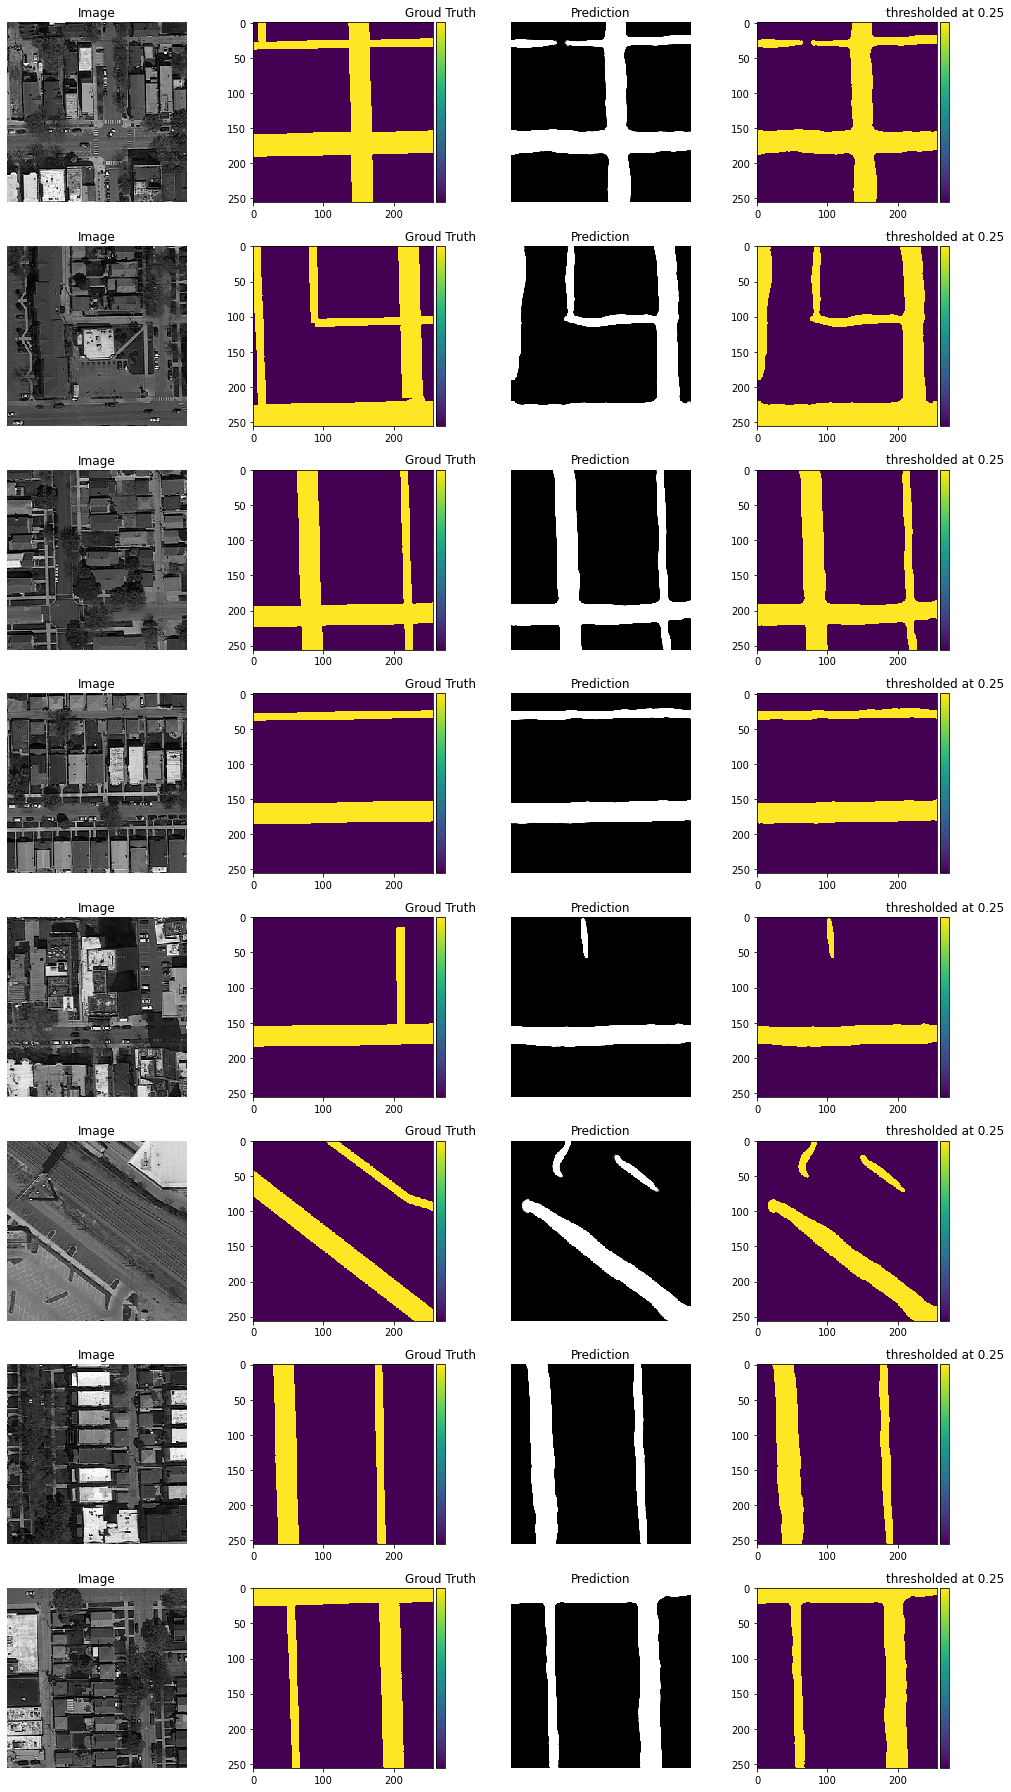

In [ ]:
ix = random.randint(0, len(predictions))
num_samples = 8

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()




```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

